<h2><center> <span style = "font-family: Babas; font-size: 2em;"> Higgs Boson Event Detection </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Part 2. Modeling </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Sugata Ghosh </span> </center></h4>

---

In [**particle physics**](https://en.wikipedia.org/wiki/Particle_physics), an **event** refers to the results just after a [**fundamental interaction**](https://en.wikipedia.org/wiki/Fundamental_interaction) took place between subatomic particles, occurring in a very short time span, at a well-localized region of space. A **background event** is explained by the existing theories and previous observations. On the other hand, a **signal event** indicates a process that cannot be described by previous observations and leads to the potential discovery of a new particle. 

In the present notebook, we build a [**neural network**](https://en.wikipedia.org/wiki/Neural_network) and train it on the data provided in the Kaggle competition [**Higgs Boson Machine Learning Challenge**](https://www.kaggle.com/competitions/higgs-boson/) to predict if a given event is background or signal. For a detailed backdrop of the problem and [**exploratory data analysis**](https://en.wikipedia.org/wiki/Exploratory_data_analysis) on the provided data, the reader is referred to the prequel notebook [**Higgs Boson Event Detection - Part 1. EDA**](https://www.kaggle.com/code/sugataghosh/higgs-boson-event-detection-part-1-eda). We shall be using a number of observations from the prequel notebook, in particular in the **preprocessing** and **feature engineering** stages. 

We use the [**approximate median significance**](https://www.kaggle.com/competitions/higgs-boson/overview/evaluation) (AMS) metric to evaluate the models. The final model obtains a training AMS of $2.500144$ and test AMS of $1.200022$. It achieves a training accuracy of $0.82707$ and a test accuracy of $0.82410$.

---

### Contents

- **Data**
- **Evaluation Metric**
- **Train-Test Split**
- **Preprocessing**
- **Feature Engineering**
- **Baseline Model**
- **Hyperparameter Tuning**
- **Prediction and Evaluation**
- **Acknowledgements**
- **References**

In [1]:
%%capture
# Importing libraries
import time, psutil, os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

!pip install scikeras
from scikeras.wrappers import KerasClassifier

To make the results reproducible, we fix the random seeds. Also, we set `random_state = 0` in both `train_test_split` and `KerasClassifier` at later stages of the notebook.

In [2]:
# Setting random seeds
os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# 1. Data

Source: **training.csv** from **https://www.kaggle.com/competitions/higgs-boson/data**

The dataset contains $250000$ observations. It has $30$ **feature variables**, along with **EventId**, **Weight** and **Label**.

In [4]:
# Loading the dataset
data = pd.read_csv('../input/higgs-boson/training.zip')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage         62.94 MB
Dataset shape    (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [5]:
# A typical observation from the dataset
data.loc[data.index[0]]

EventId                          100000
DER_mass_MMC                     138.47
DER_mass_transverse_met_lep      51.655
DER_mass_vis                     97.827
DER_pt_h                          27.98
DER_deltaeta_jet_jet               0.91
DER_mass_jet_jet                124.711
DER_prodeta_jet_jet               2.666
DER_deltar_tau_lep                3.064
DER_pt_tot                       41.928
DER_sum_pt                       197.76
DER_pt_ratio_lep_tau              1.582
DER_met_phi_centrality            1.396
DER_lep_eta_centrality              0.2
PRI_tau_pt                       32.638
PRI_tau_eta                       1.017
PRI_tau_phi                       0.381
PRI_lep_pt                       51.626
PRI_lep_eta                       2.273
PRI_lep_phi                      -2.414
PRI_met                          16.824
PRI_met_phi                      -0.277
PRI_met_sumet                   258.733
PRI_jet_num                           2
PRI_jet_leading_pt               67.435


**Dataset synopsis:**

- Number of observations: $250000$
- Number of columns: $33$
- Number of integer columns: $2$
- Number of float columns: $30$
- Number of object columns: $1$
- Number of duplicate observations: $0$
- Constant columns: None
- Number of columns with missing values: $0$
- Memory Usage: $62.94$ MB

The target `Label` is a binary variable, taking values `b` and `s`, indicating the status of an event.
\begin{align*}
&\text{b} \,\,\mapsto \text{background event}\\
&\text{s} \,\,\mapsto \text{signal event}
\end{align*}

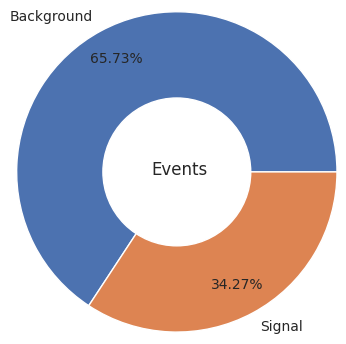

In [6]:
# Frequency comparison of labels
plt.figure(figsize = (6, 4))
ax = plt.subplot(1, 1, 1)
label_dict = {'b': 'Background', 's': 'Signal'}
plt.pie(
    data['Label'].replace(label_dict, inplace = False).value_counts(),
    labels = data['Label'].replace(label_dict, inplace = False).value_counts().index,
    autopct = '%1.2f%%',
    pctdistance = 0.8,
    shadow = False,
    radius = 1.3,
    textprops = {'fontsize' : 10}
)
circle = plt.Circle((0, 0), 0.6, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(circle)
ax.text(-0.21, -0.025, 'Events', fontsize = 12)
ax.set_xlabel('')
# plt.suptitle("Frequency comparison of labels", fontsize = 12)
plt.subplots_adjust(wspace = 0.4)
plt.show()

# 2. Evaluation Metric

The [**evaluation metric**](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers), used in this project, is the **approximate median significance** (AMS), given by

$$ AMS := \sqrt{2\left(\left(s+b+b_r\right)\log{\left(1+\frac{s}{b+b_r}\right)}-s\right)}, \tag{1}$$

where
- $s:$ unnormalized [**true positive rate**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity),
- $b:$ unnormalized [**false positive rate**](https://en.wikipedia.org/wiki/False_positive_rate),
- $b_r = 10:$ constant regularization term,
- $\log:$ [**natural logarithm**](https://en.wikipedia.org/wiki/Natural_logarithm).

Precisely, let $(y_1, \ldots, y_n) \in \{\text{b},\text{s}\}^n$ be the vector of true test labels ($\text{b}$ indicating background event and $\text{s}$ indicating signal event) and let $(\hat{y}_1, \ldots, \hat{y}_n) \in \{\text{b},\text{s}\}^n$ be the vector of predicted test labels. Also let $(w_1, \ldots, w_n) \in {\mathbb{R}^+}^n$ be the vector of weights, where $\mathbb{R}^+$ denotes the set of positive real numbers. Then

$$ s = \sum_{i=1}^n w_i \mathbb{1}\left\{y_i = s\right\} \mathbb{1}\left\{\hat{y_i} = s\right\} \tag{2}$$

and

$$ b = \sum_{i=1}^n w_i \mathbb{1}\left\{y_i = b\right\} \mathbb{1}\left\{\hat{y_i} = s\right\}, \tag{3}$$

where the [**indicator function**](https://en.wikipedia.org/wiki/Indicator_function) $\mathbb{1}\left\{S\right\}$ is $1$ if $S$ is true and $0$ otherwise.

In [7]:
# Function to compute s and b
def compute_s_b(y_true, y_pred, weight):
    """
    Computes unnormalized true positive rate (s) and unnormalized false positive rate (b)
    Args:
        y_true (array_like, shape (m, )): Array of 0/1 encoded true labels
        y_pred (array_like, shape (m, )): Array of 0/1 encoded predicted labels
        weight (array_like, shape (m, )): Array of float weights
            
    Returns:
        s (scalar): Unnormalized true positive rate, given in (2)
        b (scalar): Unnormalized false positive rate, given in (2)
    """
    assert len(y_true) == len(y_pred) == len(weight), "Lengths of the arguments do not match"
    s, b = 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            s += weight[i]
        if y_true[i] == 0 and y_pred[i] == 1:
            b += weight[i]
    return s, b

In [8]:
# Function to compute AMS
def compute_ams(y_true, y_pred, weight):
    """
    Computes approximate median significance (ams)
    Args:
        y_true (array_like, shape (m, )): Array of 0/1 encoded true labels
        y_pred (array_like, shape (m, )): Array of 0/1 encoded predicted labels
        weight (array_like, shape (m, )): Array of float weights
            
    Returns:
        ams (scalar): Approximate median significance, given in (1)
    """
    assert len(y_true) == len(y_pred) == len(weight), "Lengths of the arguments do not match"
    s, b = compute_s_b(y_true, y_pred, weight)
    b_r = 10
    ams = np.sqrt(2 * ((s + b + b_r) * np.log(1 + (s / (b + b_r))) - s))
    return ams

In [9]:
# Example
y_true_, y_pred_, weight_ = [1, 1, 0], [1, 0, 0], [1.5, 0.5, 2.5]
print(f"True labels     : {y_true_}")
print(f"Predicted labels: {y_pred_}")
print(f"Weights         : {weight_}")
print(f"AMS             : {round(compute_ams(y_true_, y_pred_, weight_), 6)}")

True labels     : [1, 1, 0]
Predicted labels: [1, 0, 0]
Weights         : [1.5, 0.5, 2.5]
AMS             : 0.463168


# 3. Train-Test Split

We [**split the data**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) in $80:20$ ratio (the [**training set**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Training_data_set) consisting of $80\%$ data, and the [**test set**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Test_data_set) consisting of the rest). We [**stratify**](https://en.wikipedia.org/wiki/Stratified_sampling) the split using the labels, so that the proportion of each label remains roughly the same in the training set and the test set.

In [10]:
# Train-test split
X, y = data.drop(['Label'], axis = 1), data['Label']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, 
                                                        stratify = y, 
                                                        random_state = 0, 
                                                        test_size = 0.2, 
                                                        shuffle = True)
df_train = pd.concat([X_train_, y_train_], axis = 1)
df_test = pd.concat([X_test_, y_test_], axis = 1)

# 4. Preprocessing

We observe that the labels are [**nominal**](https://en.wikipedia.org/wiki/Nominal_category) in nature, i.e. they do not have an inherent [**order**](https://en.wikipedia.org/wiki/Order_theory). To encode the labels, we use a dictionary to map them to integer values in the following way: $\text{b} \mapsto 0$ and $\text{s} \mapsto 1$.

In [11]:
# Manual encoding of labels
label_dict_encoding = {'b': 0, 's': 1}
df_train['Label'].replace(label_dict_encoding, inplace = True)
df_test['Label'].replace(label_dict_encoding, inplace = True)

In [12]:
# Dropping the 'EventID' column
df_train.drop('EventId', axis = 1, inplace = True)
df_test.drop('EventId', axis = 1, inplace = True)

We observe that $11$ columns in the dataset contains the value $-999$, which is very different from the other values taken by the respective features. We suspect that these are missing values filled in by a constant of arbitrary choice and drop these columns from the dataset.

In [13]:
# Proportion of the value -999 in the dataset columns which contains the value -999
index_999 = [col for col in data.columns if -999 in data[col].value_counts().index]
def minus_999(df):
    df_999 = [df[col].value_counts()[-999]/len(df) for col in index_999]
    return pd.Series(index = index_999, data = df_999)

df_minus_999 = pd.DataFrame()
df_minus_999['Training set'] = minus_999(df_train).values
df_minus_999['Test set'] = minus_999(df_test).values
df_minus_999.set_index(minus_999(df_train).index, inplace = True)
df_minus_999.style.set_caption("Proportion of the value -999 in the dataset columns which contain -999")

,Training set,Test set
DER_mass_MMC,0.152575,0.151980
DER_deltaeta_jet_jet,0.710490,0.707180
DER_mass_jet_jet,0.710490,0.707180
DER_prodeta_jet_jet,0.710490,0.707180
DER_lep_eta_centrality,0.710490,0.707180
PRI_jet_leading_pt,0.400230,0.397340
PRI_jet_leading_eta,0.400230,0.397340
PRI_jet_leading_phi,0.400230,0.397340
PRI_jet_subleading_pt,0.710490,0.707180
PRI_jet_subleading_eta,0.710490,0.707180


In [14]:
# Dropping columns with the value -999
df_train.drop(index_999, axis = 1, inplace = True)
df_test.drop(index_999, axis = 1, inplace = True)

Furthermore, we observe in the [**prequel notebook**](https://www.kaggle.com/code/sugataghosh/higgs-boson-event-detection-part-1-eda) that the following groups have shown extremely high positive correlation structure within themselves, i.e. any two features from a single group has extremely high correlation coefficient.

- `DER_deltaeta_jet_jet`, `DER_mass_jet_jet`, `DER_prodeta_jet_jet`, `DER_lep_eta_centrality`, `PRI_jet_subleading_pt`, `PRI_jet_subleading_eta`, `PRI_jet_subleading_phi`
- `DER_sum_pt`, `PRI_met_sumet`, `PRI_jet_all_pt`
- `PRI_jet_leading_pt`, `PRI_jet_leading_eta`, `PRI_jet_leading_phi`

The first group and the last group are subsets of the dropped columns and we can explain that the high frequency of the value $-999$ contributes significantly to their extremely high correlation. The middle group of three features, though, does not have the same explanation. We keep one from these columns and drop the other two.

In [15]:
# Dropping columns due to high correlation
df_train.drop(['PRI_met_sumet', 'PRI_jet_all_pt'], axis = 1, inplace = True)
df_test.drop(['PRI_met_sumet', 'PRI_jet_all_pt'], axis = 1, inplace = True)

# 5. Feature Engineering

We note the following observations from the prequel notebook.

- Columns with extreme skewness (absolute value greater than $3$ in the dataset): `DER_mass_MMC`, `DER_mass_vis`, `DER_pt_tot`, `PRI_tau_pt`, `PRI_lep_pt`, `PRI_met`, `PRI_jet_subleading_pt` 
- Columns with high skewness (absolute value between $1$ and $3$ in the dataset): `DER_mass_transverse_met_lep`, `DER_pt_h`, `DER_mass_jet_jet`, `DER_sum_pt`, `DER_pt_ratio_lep_tau`, `PRI_met_sumet`, `PRI_jet_leading_pt`, `PRI_jet_all_pt`
- Columns with moderate skewness (absolute value between $0.5$ and $1$ in the dataset): `DER_deltaeta_jet_jet`

In [16]:
cols_skewed_extreme = [
    'DER_mass_MMC', 
    'DER_mass_vis', 
    'DER_pt_tot', 
    'PRI_tau_pt', 
    'PRI_lep_pt', 
    'PRI_met', 
    'PRI_jet_subleading_pt'
]

cols_skewed_high = [
    'DER_mass_transverse_met_lep',
    'DER_pt_h',
    'DER_mass_jet_jet',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'PRI_met_sumet',
    'PRI_jet_leading_pt',
    'PRI_jet_all_pt'
]

cols_skewed_moderate = ['DER_deltaeta_jet_jet']

In [17]:
def cols_skewed_selector(mode = 'moderate+'):
    """
    Selects skewed columns to transform
    Args:
        mode (string): 'extreme', 'high+' or 'moderate+'
            Choose 'extreme' to select features with absolute value of skewness greater than 3
            Choose 'high+' to select features with absolute value of skewness greater than 1
            Choose 'moderate+' to select features with absolute value of skewness greater than 0.5
            
    Returns:
        cols_transform (list): List of columns to be transformed
    """
    if mode == 'extreme':
        cols_skewed = cols_skewed_extreme
        cols_transform = [col for col in df_train if col in cols_skewed]
    elif mode == 'high+':
        cols_skewed = cols_skewed_extreme + cols_skewed_high
        cols_transform = [col for col in df_train if col in cols_skewed]
    else:
        cols_skewed = cols_skewed_extreme + cols_skewed_high + cols_skewed_moderate
        cols_transform = [col for col in df_train if col in cols_skewed]
    return cols_transform

In [18]:
# Selecting columns to be transformed
cols_transform = cols_skewed_selector(mode = 'moderate+')
print("Features to be transformed:")
cols_transform

Features to be transformed:


['DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'PRI_tau_pt',
 'PRI_lep_pt',
 'PRI_met']

First we apply location change $x \mapsto x - \min(x) + 1$ on the features to be transformed, to make their range start from $1$. The relocated variables fall inside the range $[1, \infty)$. Now we apply the log transformation $y \mapsto \log{y}$. The relocation preceding the log transformation ensures that there are no negative values to be fed to the $\log$ function. The addition of $1$ ensures that there are no values very close to $0$, which the log transformation maps to extreme negative values. Note that we use the same $\min(x)$ from the training data in the test data, to keep the transformation same for the two datasets.

In [19]:
def log_transform(df_train_in, df_test_in, cols_transform):
    """
    Selects skewed columns to transform
    Args:
        df_train_in (DataFrame, shape (m1, n)): Input training dataframe
        df_test_in (DataFrame, shape (m2, n)) : Input test dataframe
        cols_transform (list)                 : List of columns to be transformed
            
    Returns:
        df_train_out (DataFrame, shape (m1, n)): output training dataframe
        df_test_out (DataFrame, shape (m2, n)) : output test dataframe
    """
    df_train_out, df_test_out = df_train_in.copy(deep = True), df_test_in.copy(deep = True)
    for col in cols_transform:
        min_ = df_train_out[col].min()
        df_train_out[col] = df_train_out[col] - min_ + 1
        df_train_out[col] = np.log(df_train_out[col])
        df_test_out[col] = df_test_out[col] - min_ + 1
        df_test_out[col] = np.log(df_test_out[col])
    return df_train_out, df_test_out

In [20]:
# Modified log transformation of skewed features
df_train, df_test = log_transform(df_train, df_test, cols_transform)

We employ **min-max normalization** on the float columns in both the training set and the validation set. To keep the transformation the same, we use the minimum and maximum values of the training columns only for both sets. Using the minimum and maximum values of the validation columns for both sets would have led to **data leakage**.

In [21]:
def minmax_normalizer(df_train_in, df_test_in, cols):
    """
    Selects skewed columns to transform
    Args:
        df_train_in (DataFrame, shape (m1, n)): input training dataframe
        df_test_in (DataFrame, shape (m2, n)) : input test dataframe
        cols (list)                           : list of columns to be normalized
        
    Returns:
        df_train_out (DataFrame, shape (m1, n)): output training dataframe
        df_test_out (DataFrame, shape (m2, n)) : output test dataframe
    """
    df_train_out, df_test_out = df_train_in.copy(deep = True), df_test_in.copy(deep = True)
    for col in cols:
        min_, max_ = df_train_out[col].min(), df_train_out[col].max()
        df_train_out[col] = (df_train_out[col] - min_) / (max_ - min_)
        df_test_out[col] = (df_test_out[col] - min_) / (max_ - min_)
    return df_train_out, df_test_out

In [22]:
# Min-max normalization of non-constant float columns in the training set and the test set
cols_minmax = [col for col in df_train.columns if col not in ['Weight', 'Label']]
cols_minmax = [col for col in cols_minmax if df_train[col].dtypes == 'float64']
cols_minmax = [col for col in cols_minmax if df_train[col].nunique() > 1]

df_train, df_test = minmax_normalizer(df_train, df_test, cols_minmax)

# 6. Baseline Model

In [23]:
# Splitting features, weight and label
def split_data(df):
    return df.drop(['Weight', 'Label'], axis = 1), df['Label'].values, df['Weight'].values

X_train, y_train, w_train = split_data(df_train)
X_test, y_test, w_test = split_data(df_test)

In [24]:
# Model creation and compilation
def createModel(learning_rate = 0.001):
    model = Sequential()
    model.add(Dense(units = 16, input_dim = len(X_train.columns), activation = 'relu')) 
    model.add(Dense(units = 8, activation = 'relu')) 
    model.add(Dense(units = 8, activation = 'relu')) 
    model.add(Dense(units = 1, activation = 'sigmoid')) 
    
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                  metrics = ['accuracy'])
    
    return model

model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                288       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 505 (1.97 KB)
Trainable params: 505 (1.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Early stopping callback
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.001, 
                          patience = 20, 
                          verbose = 0, 
                          mode = 'auto',
                          start_from_epoch = 60)

In [26]:
# Modified linear schedule function
def scheduler_modified_linear(epoch, learning_rate):
    if epoch < 40:
        return learning_rate
    else:
        return learning_rate * (100 - epoch) / (100 - epoch + 1)

In [27]:
# Modified exponential schedule function
def scheduler_modified_exponential(epoch, learning_rate):
    if epoch < 40:
        return learning_rate
    else:
        return learning_rate * math.exp(-0.1)

In [28]:
# Learning rate scheduler callback
learning_rate_scheduler = LearningRateScheduler(scheduler_modified_linear)

In [29]:
# Model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath = 'best_model.h5', 
                                   monitor = 'val_loss', 
                                   save_best_only = True)

In [30]:
%%time
# Model fitting
history = model.fit(X_train, 
                    y = y_train, 
                    batch_size = 32, 
                    epochs = 100, 
                    validation_split = 0.2, 
                    callbacks = [earlystop, learning_rate_scheduler, model_checkpoint],
                    verbose = 0)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CPU times: user 19min 20s, sys: 1min 48s, total: 21min 8s
Wall time: 15min 30s


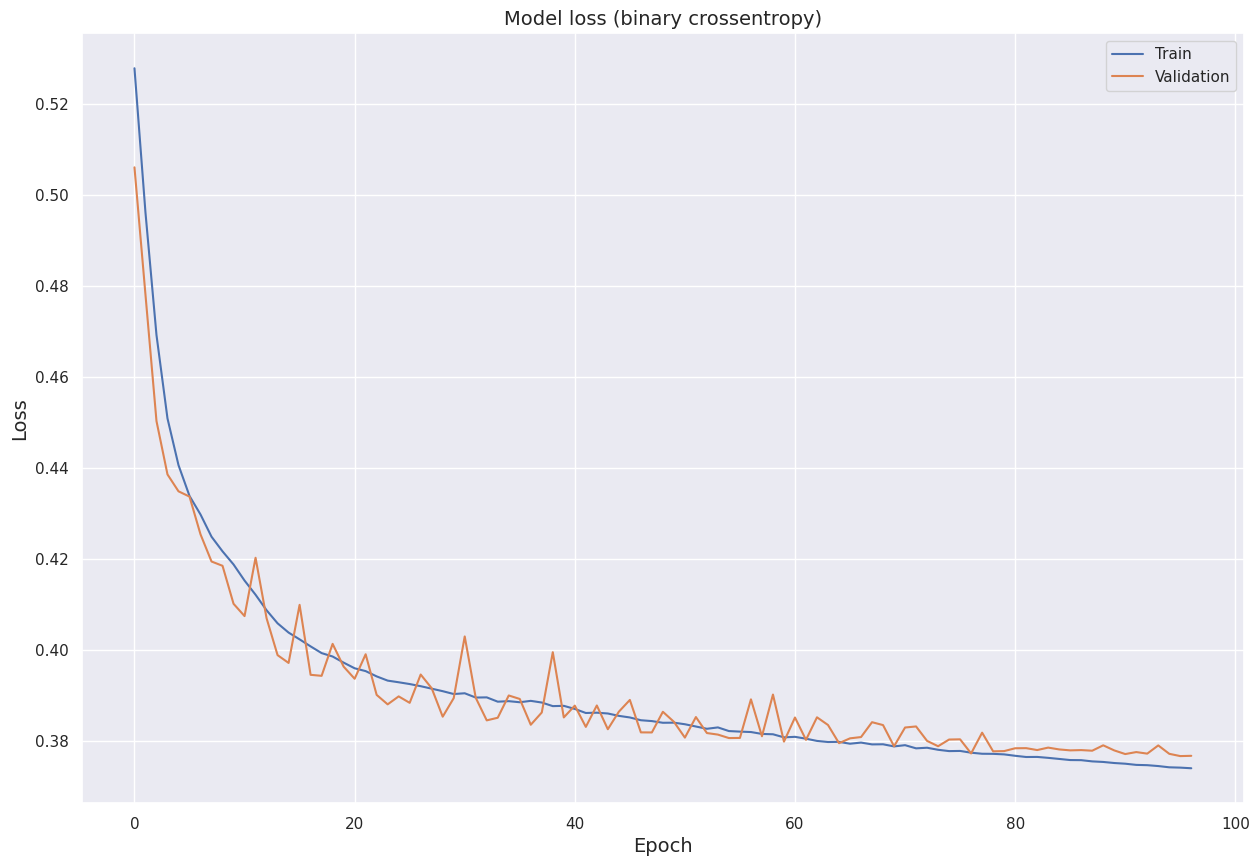

In [31]:
# Visualization of model loss
plt.figure(figsize = (15, 10))
plt.title('Model loss (binary crossentropy)', fontsize = 14)
sns.lineplot(data = history.history['loss'], label = 'Train')
sns.lineplot(data = history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.legend()
plt.savefig('bincross.jpg')
plt.show()

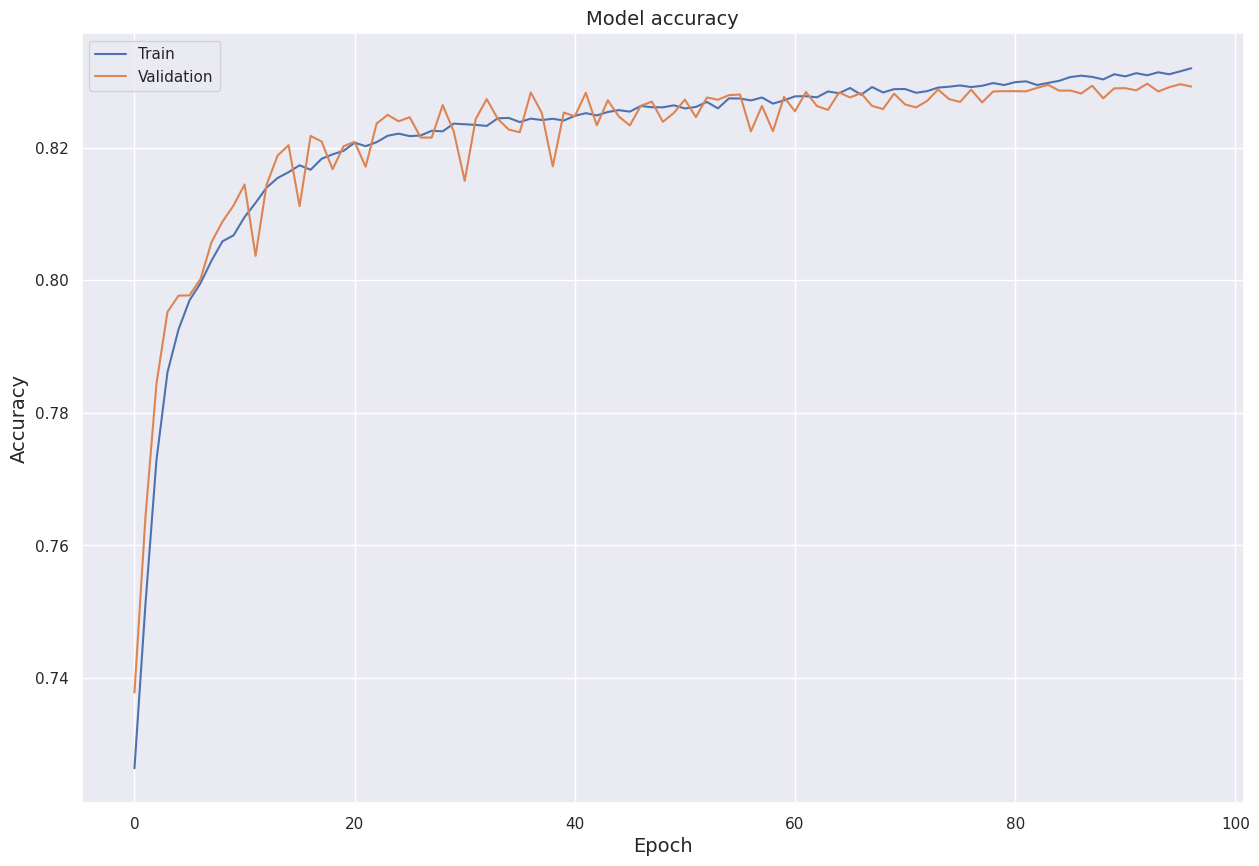

In [32]:
# Visualization of model accuracy
plt.figure(figsize = (15, 10))
plt.title('Model accuracy', fontsize = 14)
sns.lineplot(data = history.history['accuracy'], label = 'Train')
sns.lineplot(data = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.savefig('accuracy.jpg')
plt.show()

In [33]:
# Loading best weights
model.load_weights('best_model.h5')

In [34]:
# Prediction of label 1 probabilities
y_train_proba = model.predict(X_train, verbose = 0).flatten()
y_test_proba = model.predict(X_test, verbose = 0).flatten()

In [35]:
def proba_to_pred(y_proba, threshold = 0.5):
    """
    Computes vector of binary predictions from an array of probabilities and a specified threshold
    Args:
        y_proba (array_like, shape (m, )): Array of label 1 probabilities
        threshold (scalar)               : System predicts 0 if probability < threshold, 1 otherwise
    
    Returns:
        y_pred (array_like, shape (m, )): List of predicted labels
    """
    y_pred = np.array([0 if y_proba[i] < threshold else 1 for i in range(len(y_proba))])
    return y_pred

In [36]:
# Conversion to labels
y_train_pred = proba_to_pred(y_train_proba, threshold = 0.5)
y_test_pred = proba_to_pred(y_test_proba, threshold = 0.5)

In [37]:
# AMS
ams_train = compute_ams(y_train, y_train_pred, w_train)
ams_test = compute_ams(y_test, y_test_pred, w_test)

print(f"Training AMS: {round(ams_train, 6)}")
print(f"Test AMS    : {round(ams_test, 6)}")

Training AMS: 2.509776
Test AMS    : 1.21426


# 7. Hyperparameter Tuning

In [38]:
# Model creation
model_ = KerasClassifier(model = createModel, 
                         optimizer = 'adam', 
                         loss = 'binary_crossentropy', 
                         batch_size = 32, 
                         epochs = 100, 
                         learning_rate = 0.001, 
                         callbacks = [earlystop, learning_rate_scheduler, model_checkpoint], 
                         random_state = 0, 
                         verbose = 0)

In [39]:
%%time
# Grid search
param_grid = {
    'batch_size'   : [32, 64, 128],
    'learning_rate': [0.001, 0.003, 0.01]
}

grid = GridSearchCV(estimator = model_, 
                    param_grid = param_grid, 
                    cv = 5,
                    scoring = 'accuracy', 
                    n_jobs = -1, 
                    refit = True, 
                    verbose = 1)

grid_result = grid.fit(X_train, 
                       y = y_train, 
                       validation_split = 0.2, 
                       callbacks = [earlystop, learning_rate_scheduler, model_checkpoint],
                       verbose = 0)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CPU times: user 13min 46s, sys: 43.6 s, total: 14min 29s
Wall time: 2h 32min 51s


In [40]:
# Summary of grid search
results = pd.DataFrame(grid.cv_results_)
cols = [
    'rank_test_score', 
    'param_batch_size', 
    'param_learning_rate', 
    'mean_test_score', 
    'std_test_score'
]
results[cols].sort_values(by = 'rank_test_score')

,rank_test_score,param_batch_size,param_learning_rate,mean_test_score,std_test_score
7,1,128,0.003,0.827820,0.001155
0,2,32,0.001,0.827250,0.002666
4,3,64,0.003,0.826730,0.001113
1,4,32,0.003,0.826685,0.001669
8,5,128,0.01,0.826160,0.002927
3,6,64,0.001,0.825825,0.001768
5,7,64,0.01,0.825390,0.001404
6,8,128,0.001,0.824590,0.001303
2,9,32,0.01,0.820960,0.002107


In [41]:
# Summary of best estimator
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy: {round(grid.best_score_, 6)}")

Best parameters: {'batch_size': 128, 'learning_rate': 0.003}
Best cross-validation accuracy: 0.82782


# 8. Prediction and Evaluation

In [42]:
# Prediction of label 1 probabilities
best_model_ = grid.best_estimator_

y_train_proba_ = best_model_.predict_proba(X_train, verbose = 0)[:, 1:].flatten()
y_test_proba_ = best_model_.predict_proba(X_test, verbose = 0)[:, 1:].flatten()

In [43]:
# Conversion to labels using the best threshold
y_train_pred_ = proba_to_pred(y_train_proba_, threshold = 0.5)
y_test_pred_ = proba_to_pred(y_test_proba_, threshold = 0.5)

# Alternative code when threshold = 0.5
# without requiring the computation of `y_train_proba_` and `y_test_proba_`
# y_train_pred_ = best_model_.predict(X_train, verbose = 0)
# y_test_pred_ = best_model_.predict(X_test, verbose = 0)

In [44]:
# AMS
ams_train_ = compute_ams(y_train, y_train_pred_, w_train)
ams_test_ = compute_ams(y_test, y_test_pred_, w_test)

print(f"Training AMS: {round(ams_train_, 6)}")
print(f"Test AMS    : {round(ams_test_, 6)}")

Training AMS: 2.500144
Test AMS    : 1.200022


In [45]:
# Accuracy
accuracy_train_ = accuracy_score(y_train, y_train_pred_)
accuracy_test_ = accuracy_score(y_test, y_test_pred_)

print(f"Training accuracy: {round(accuracy_train_, 6)}")
print(f"Test accuracy    : {round(accuracy_test_, 6)}")

Training accuracy: 0.82707
Test accuracy    : 0.8241


In [46]:
# Function to compute and print confusion matrix
def conf_matrix(y_true, y_pred, n_class, class_names = 'default', figsize = (6.25, 5), font_scale = 1, annot_kws_size = 12):
    if class_names == 'default':
        class_names = np.arange(n_class)
    tick_marks_y = np.arange(n_class) + 0.5
    tick_marks_x = np.arange(n_class) + 0.5
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(n_class), range(n_class))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.savefig('confmat.jpg')
    plt.show()

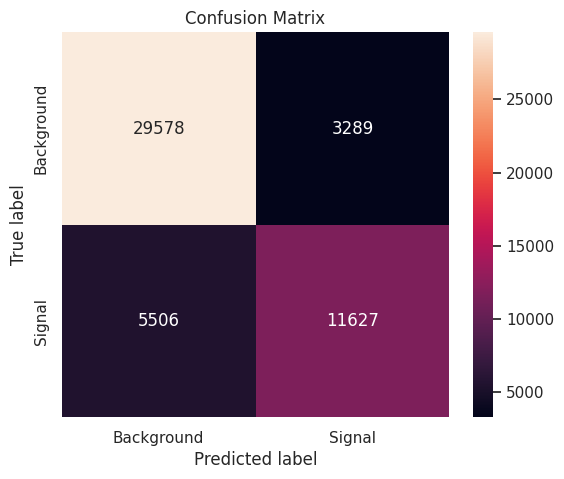

In [47]:
# Confusion matrix
conf_matrix(y_test, y_test_pred_, n_class = 2, class_names = ['Background', 'Signal'])

# Acknowledgements

- [**Higgs Boson Machine Learning Challenge dataset**](https://www.kaggle.com/competitions/higgs-boson/data)
- [**Implementation of the scikit-learn classifier API for Keras**](https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html)

# References

- [**Approximate median significance**](https://www.kaggle.com/competitions/higgs-boson/overview/evaluation)
- [**Evaluation metric**](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)
- [**Exploratory data analysis**](https://en.wikipedia.org/wiki/Exploratory_data_analysis)
- [**False positive rate**](https://en.wikipedia.org/wiki/False_positive_rate)
- [**Fundamental interaction**](https://en.wikipedia.org/wiki/Fundamental_interaction)
- [**Indicator function**](https://en.wikipedia.org/wiki/Indicator_function)
- [**Order theory**](https://en.wikipedia.org/wiki/Order_theory)
- [**Natural logarithm**](https://en.wikipedia.org/wiki/Natural_logarithm)
- [**Nominal category**](https://en.wikipedia.org/wiki/Nominal_category)
- [**Neural network**](https://en.wikipedia.org/wiki/Neural_network)
- [**Particle physics**](https://en.wikipedia.org/wiki/Particle_physics)
- [**Stratified sampling**](https://en.wikipedia.org/wiki/Stratified_sampling)
- [**Test set**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Test_data_set)
- [**Training set**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Training_data_set)
- [**Train-test split**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [**True positive rate**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)

In [48]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         10184.52 seconds
Process memory usage          1802.48 MB
